In [1]:
from d2l import torch as d2l
import torch
from torch import nn
import torchvision as tv
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from PIL import Image

from sklearn.model_selection import train_test_split

import os
import pandas as pd
import numpy as np
import joblib
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
import albumentations
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# check device
#DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
transform=transforms.Compose([transforms.Resize(224),
                        transforms.CenterCrop(224),
                        tv.transforms.Grayscale(num_output_channels=1),
                             transforms.ToTensor()])

In [3]:
#https://debuggercafe.com/creating-efficient-image-data-loaders-in-pytorch-for-deep-learning/

In [4]:
class ImageDataset(Dataset):
    
    def __init__(self, path, labels, tfms=None):
        # data loading
        self.X = path
        self.y = labels
        
    def __getitem__(self, index):
        # dataset[0]
        image = Image.open(self.X[index]).convert('RGB')
        image = transform(image)
        #image = np.transpose(image, (2, 0, 1))
        type(image)
        label = self.y[index]
        return image, torch.tensor(label, dtype=torch.long)
        
    def __len__(self):
        # len(dataset)
        return(len(self.X))
    

In [5]:
df = pd.read_csv('../input/data.csv')
X_ = df.image_path.values
y_ = df.target.values
df

,image_path,target
0,../imageTraining\vor\Heidelberg_UB_Signatur_Se...,1.0
1,../imageTraining\vor\Oxford_Bodleian-Library_M...,1.0
2,../imageTraining\vor\Frankreich_Lombardei_UniH...,1.0
3,../imageTraining\vor\Frankreich_UniHeidelberg_...,1.0
4,../imageTraining\nach\Basel_UB-AN-IV_4r_EvtlRh...,0.0
...,...,...
56,../imageTraining\vor\Cologny_FondationMartinBo...,1.0
57,../imageTraining\nach\Bayern_Bayerische_Staats...,0.0
58,../imageTraining\vor\Oxford_Bodleian-Library_M...,1.0
59,../imageTraining\vor\StGallen_csg-1920_1_StGal...,1.0


In [6]:
(xtrain, xtest, ytrain, ytest) = (train_test_split(X_, y_,test_size=0.25, random_state=42))

In [7]:
batch_size = 10
train_dataset = ImageDataset(xtrain, ytrain, 0)
test_dataset = ImageDataset(xtest, ytest, 0)
train_iter = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size)
test_iter = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size)

for batch in train_iter:
    print(batch[0].shape) # or anything else you want to do
    break


torch.Size([10, 1, 224, 224])


### AlexNet
- https://d2l.ai/chapter_convolutional-modern/alexnet.html

In [8]:
net = nn.Sequential(
    # Here, we use a larger 11 x 11 window to capture objects. At the same
    # time, we use a stride of 4 to greatly reduce the height and width of the
    # output. Here, the number of output channels is much larger than that in
    # LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Make the convolution window smaller, set padding to 2 for consistent
    # height and width across the input and output, and increase the number of
    # output channels
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Use three successive convolutional layers and a smaller convolution
    # window. Except for the final convolutional layer, the number of output
    # channels is further increased. Pooling layers are not used to reduce the
    # height and width of input after the first two convolutional layers
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # Here, the number of outputs of the fully-connected layer is several
    # times larger than that in LeNet. Use the dropout layer to mitigate
    # overfitting
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # Output layer. Since we are using Fashion-MNIST, the number of classes is
    # 10, instead of 1000 as in the paper
    nn.Linear(4096, 10))

In [9]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'Output shape:\t',X.shape)

Conv2d Output shape:	 torch.Size([1, 96, 54, 54])
ReLU Output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d Output shape:	 torch.Size([1, 96, 26, 26])
Conv2d Output shape:	 torch.Size([1, 256, 26, 26])
ReLU Output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d Output shape:	 torch.Size([1, 256, 12, 12])
Conv2d Output shape:	 torch.Size([1, 384, 12, 12])
ReLU Output shape:	 torch.Size([1, 384, 12, 12])
Conv2d Output shape:	 torch.Size([1, 384, 12, 12])
ReLU Output shape:	 torch.Size([1, 384, 12, 12])
Conv2d Output shape:	 torch.Size([1, 256, 12, 12])
ReLU Output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d Output shape:	 torch.Size([1, 256, 5, 5])
Flatten Output shape:	 torch.Size([1, 6400])
Linear Output shape:	 torch.Size([1, 4096])
ReLU Output shape:	 torch.Size([1, 4096])
Dropout Output shape:	 torch.Size([1, 4096])
Linear Output shape:	 torch.Size([1, 4096])
ReLU Output shape:	 torch.Size([1, 4096])
Dropout Output shape:	 torch.Size([1, 4096])
Linear Output shape:	 torch.Size([1,

In [10]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # Required for BERT Fine-tuning (to be covered later)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

In [11]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            print(y.shape)
            print(y_hat.shape)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 2.053, train acc 0.733, test acc 0.875
176.5 examples/sec on cuda:0


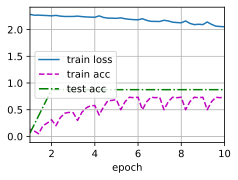

In [12]:
lr, num_epochs = 0.001, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)
torch.save(net.state_dict(), 'eko.params')

In [13]:
def create_confusion_matrix(y_true, y_predicted):
    return confusion_matrix(y_true, y_predicted)

In [14]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.get_cmap('Blues')): 
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    fig =plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(ticks=range(cm.min(), cm.max() + 1, int((cm.max() - cm.min()) / 10)))

    target_names = ['0', '1']
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, "{:,}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True value')
    plt.xlabel('Predicted value\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    #writer.add_figure(title, fig)

In [15]:
train_dataset = ImageDataset(xtrain, ytrain, 0)
train_data = torch.utils.data.DataLoader(train_dataset)

In [16]:
#X = []
#y = []
net.to('cpu')
y_true = []
y_predicted = []
softmax = nn.Softmax(dim=1)
for (image, label) in train_data:
    y_true.append(label.detach())
    y_predicted_tensor = net(image)
    y_predicted_tensor = softmax(y_predicted_tensor)
    y_predicted.append(torch.max(y_predicted_tensor, 1)[1])

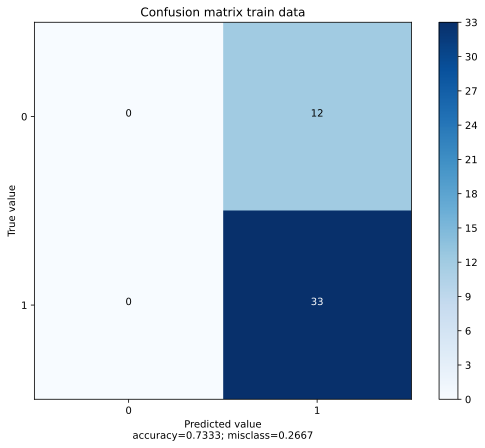

In [17]:
cm = create_confusion_matrix(y_true, y_predicted)
plot_confusion_matrix(cm, 'Confusion matrix train data')

In [18]:
train_dataset = ImageDataset(xtrain, ytrain, 0)
train_data = torch.utils.data.DataLoader(train_dataset)

In [21]:
train_dataset = ImageDataset(xtest, ytest, 0)
train_data = torch.utils.data.DataLoader(train_dataset)

In [19]:
net.to('cpu')
y_true = []
y_predicted = []
softmax = nn.Softmax(dim=1)
for (image, label) in train_data:
    y_true.append(label.detach())
    y_predicted_tensor = net(image)
    y_predicted_tensor = softmax(y_predicted_tensor)
    y_predicted.append(torch.max(y_predicted_tensor, 1)[1])

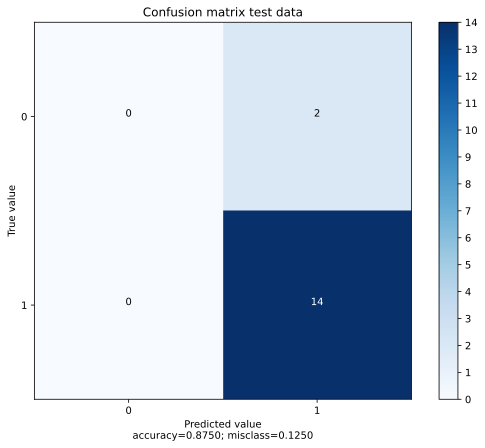

In [20]:
cm = create_confusion_matrix(y_true, y_predicted)
plot_confusion_matrix(cm, 'Confusion matrix test data')

In [22]:
dataiter = iter(train_data)
images, labels = dataiter.next()

Sequential(
  (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=6400, out_features=4096, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.5, inplace=False)
  (17): Linear(in_features=4096, out_features=4096, bias=True)
  (18): ReLU()
  (19): Dropout(p=0.5, inplace=False)
  (20): Linear(in_featu

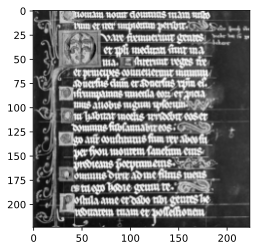

In [23]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
# create grid of images
img_grid = tv.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
#writer.add_image('old_text_image_images', img_grid)
net.to('cpu')
#writer.add_graph(net, images)